Optimal solution found!
Objective value (trips + environmental cost): 3966.78


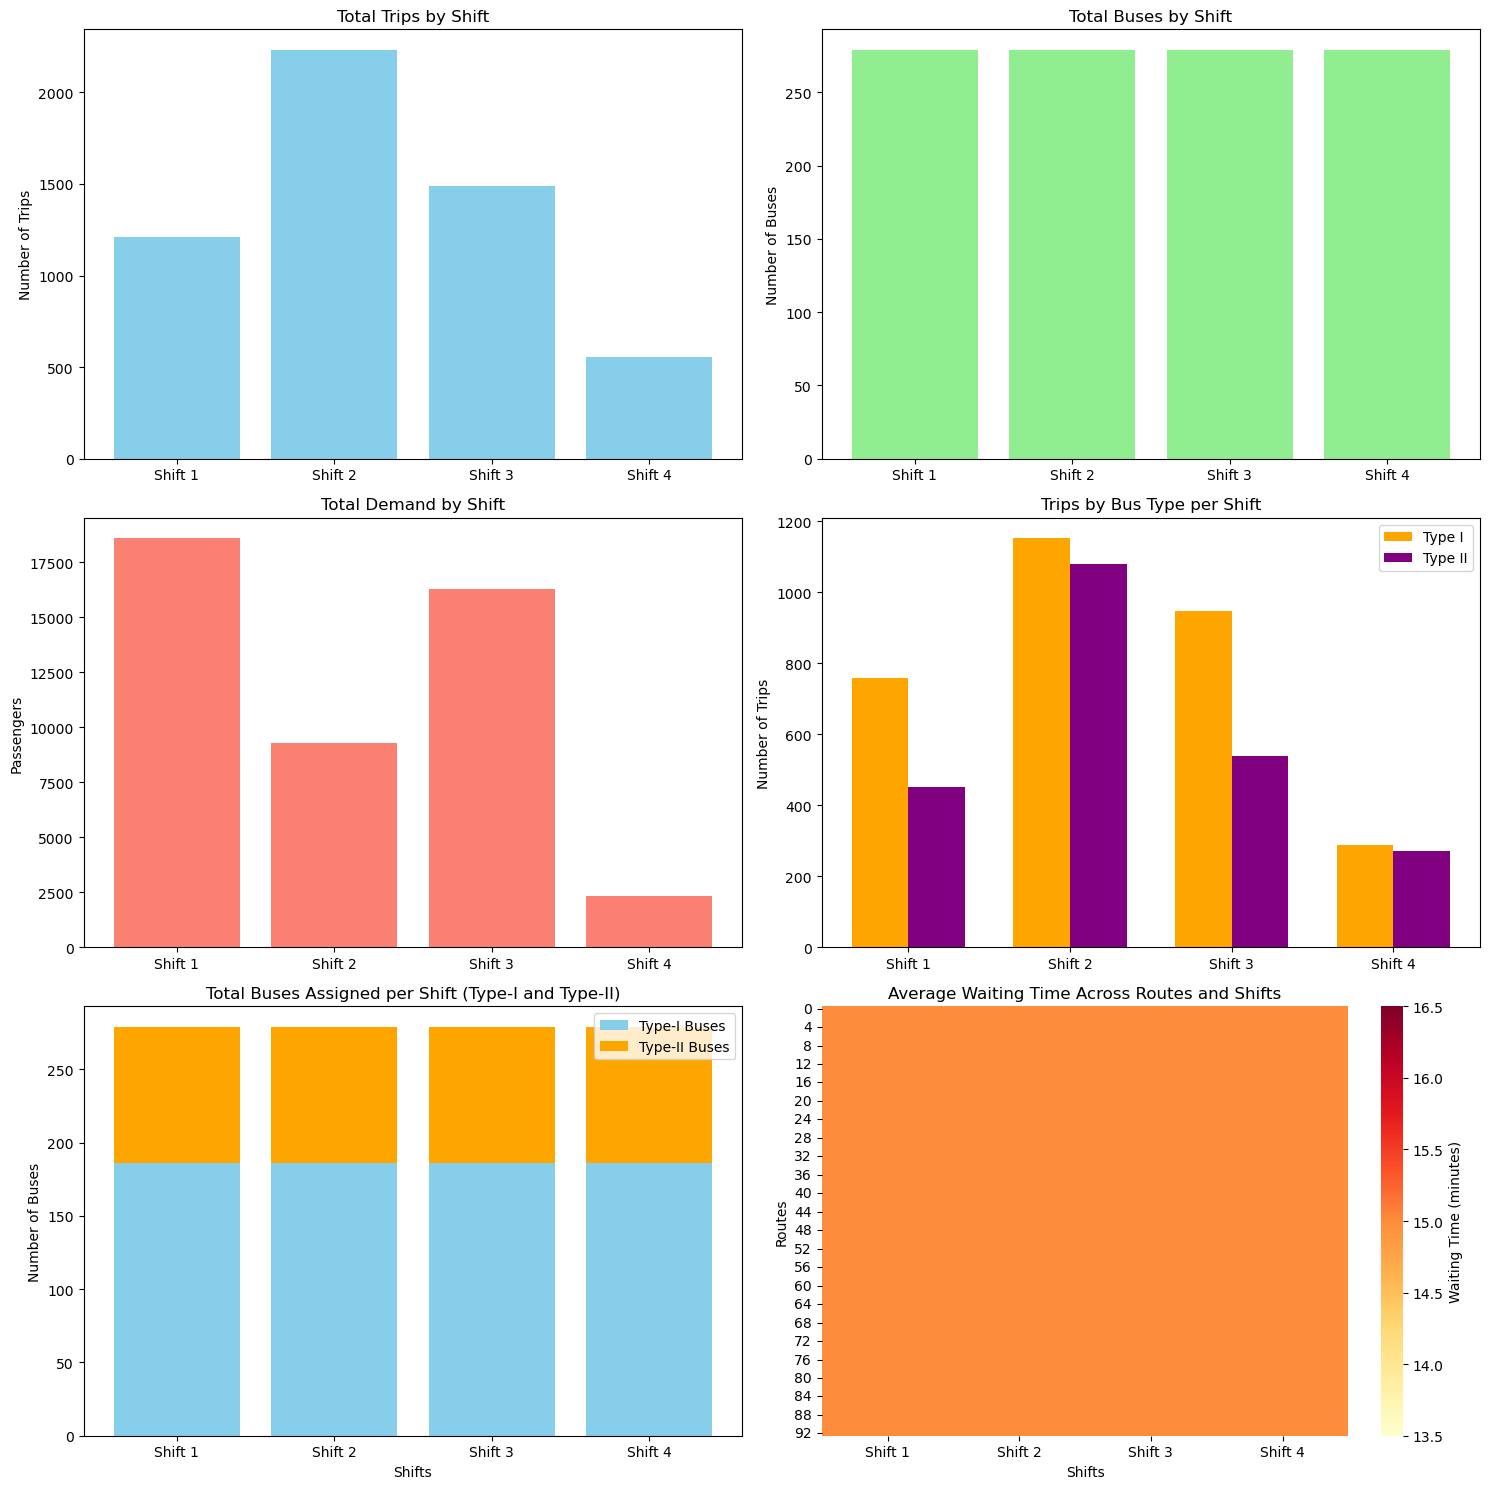


--- Summary Table by Shift ---
  Shift  Demand  Trips (Type I)  Trips (Type II)  Total Trips  Total Buses  Buses (Type I)  Buses (Type II)  Avg Waiting Time
Shift 1 18600.0           759.0            450.0       1209.0          279           186.0             93.0              15.0
Shift 2  9300.0          1152.0           1080.0       2232.0          279           186.0             93.0              15.0
Shift 3 16275.0           948.0            540.0       1488.0          279           186.0             93.0              15.0
Shift 4  2325.0           288.0            270.0        558.0          279           186.0             93.0              15.0


In [2]:
# Import required libraries
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

# Configurable Parameters
NUM_ROUTES = 93
NUM_SHIFTS = 4
FLEET_TYPE1 = 600
FLEET_TYPE2 = 90
SEAT_CAPACITY_TYPE1 = 60
SEAT_CAPACITY_TYPE2 = 90
SHIFT_DURATIONS = [195, 360, 240, 90]
DEMAND_PROPORTIONS = [0.4, 0.2, 0.35, 0.05]
BASE_ROUTE_DEMAND = 500
TRIP_DURATION = 30
traffic_factors = [[1.2, 1.0, 1.2, 1.0] for _ in range(NUM_ROUTES)]  # Peak shifts have higher traffic
E1, E2 = 1.2, 1.0  # Environmental cost per trip
alpha, beta, gamma = 0.5, 0.3, 0.2  # Weights
MAX_WAITING_TIME = 15  # Maximum acceptable waiting time in minutes

# Derived Parameters
T = [[SHIFT_DURATIONS[j] // (TRIP_DURATION * traffic_factors[i][j]) for j in range(NUM_SHIFTS)] for i in range(NUM_ROUTES)]  # [5, 12, 6, 3]
w = [d // TRIP_DURATION for d in SHIFT_DURATIONS]  # [6, 12, 8, 3]
P = [1 / NUM_ROUTES for _ in range(NUM_ROUTES)]
D = [[BASE_ROUTE_DEMAND * prop for prop in DEMAND_PROPORTIONS] for _ in range(NUM_ROUTES)]

# Create Solver
solver = pywraplp.Solver.CreateSolver('GLOP')
if not solver:
    print("Solver not created!")
    exit(1)

# Variables
x = {}
y = {}
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        x[i, j] = solver.NumVar(0, solver.infinity(), f'x_{i}_{j}')
        y[i, j] = solver.NumVar(0, solver.infinity(), f'y_{i}_{j}')

# Objective: Minimize weighted sum of trips and environmental cost (waiting time computed post-optimization)
objective = solver.Objective()
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        objective.SetCoefficient(x[i, j], alpha + gamma * E1)
        objective.SetCoefficient(y[i, j], alpha + gamma * E2)
objective.SetMinimization()

# Constraints
# 1. Demand satisfaction
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        solver.Add(SEAT_CAPACITY_TYPE1 * x[i, j] + SEAT_CAPACITY_TYPE2 * y[i, j] >= D[i][j])

# 2 & 3. Fleet limits
total_available_trips = sum(sum(T[i]) for i in range(NUM_ROUTES))
total_trips_x = sum(x[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS))
total_trips_y = sum(y[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS))
solver.Add(total_trips_x <= FLEET_TYPE1 * total_available_trips)
solver.Add(total_trips_y <= FLEET_TYPE2 * total_available_trips)

# 4. Minimum trips
total_min_trips = NUM_ROUTES * sum(w[j] for j in range(NUM_SHIFTS))
solver.Add(sum(x[i, j] + y[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS)) >= total_min_trips)

# 5 & 6. Trip limits
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        solver.Add(x[i, j] <= FLEET_TYPE1 * P[i] * T[i][j])
        solver.Add(y[i, j] <= FLEET_TYPE2 * P[i] * T[i][j])

# 7. Linear waiting time constraint: Ensure enough trips to keep waiting time below MAX_WAITING_TIME
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        min_trips = SHIFT_DURATIONS[j] / MAX_WAITING_TIME  # Minimum trips to keep waiting time <= 15 minutes
        solver.Add(x[i, j] + y[i, j] >= min_trips)

# Solve
status = solver.Solve()

# Results and Visualization
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")
    print(f"Objective value (trips + environmental cost): {objective.Value()}")

    # Collect data for visualization
    trips_by_shift = [0] * NUM_SHIFTS
    buses_by_shift = [0] * NUM_SHIFTS
    demand_by_shift = [0] * NUM_SHIFTS
    trips_type1_by_shift = [0] * NUM_SHIFTS
    trips_type2_by_shift = [0] * NUM_SHIFTS
    buses_type1_by_shift = [0] * NUM_SHIFTS
    buses_type2_by_shift = [0] * NUM_SHIFTS
    waiting_time_by_shift = [0] * NUM_SHIFTS

    # Arrays for per-route-per-shift data
    trips_type1 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    trips_type2 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    buses_type1 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    buses_type2 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    bus_utilization = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    waiting_time = np.zeros((NUM_ROUTES, NUM_SHIFTS))

    # Compute waiting time post-optimization
    for i in range(NUM_ROUTES):
        for j in range(NUM_SHIFTS):
            x_val = x[i, j].solution_value()
            y_val = y[i, j].solution_value()
            total_trips = x_val + y_val
            # Aggregate totals per shift
            trips_by_shift[j] += total_trips
            trips_type1_by_shift[j] += x_val
            trips_type2_by_shift[j] += y_val
            if T[i][j] > 0:
                buses_type1_by_shift[j] += math.ceil(x_val / T[i][j])
                buses_type2_by_shift[j] += math.ceil(y_val / T[i][j])
                buses_by_shift[j] += math.ceil(x_val / T[i][j]) + math.ceil(y_val / T[i][j])
                buses_type1[i, j] = math.ceil(x_val / T[i][j])
                buses_type2[i, j] = math.ceil(y_val / T[i][j])
            demand_by_shift[j] += D[i][j]
            # Compute waiting time: Shift Duration / Number of Trips
            w_val = SHIFT_DURATIONS[j] / total_trips if total_trips > 0 else MAX_WAITING_TIME
            waiting_time_by_shift[j] += w_val
            # Store per-route-per-shift data
            trips_type1[i, j] = x_val
            trips_type2[i, j] = y_val
            capacity_allocated = (SEAT_CAPACITY_TYPE1 * x_val + SEAT_CAPACITY_TYPE2 * y_val)
            bus_utilization[i, j] = (D[i][j] / capacity_allocated * 100) if capacity_allocated > 0 else 0
            waiting_time[i, j] = w_val

    # Convert to DataFrames
    trips_type1_df = pd.DataFrame(trips_type1, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    trips_type2_df = pd.DataFrame(trips_type2, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    buses_type1_df = pd.DataFrame(buses_type1, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    buses_type2_df = pd.DataFrame(buses_type2, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    utilization_df = pd.DataFrame(bus_utilization, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    waiting_time_df = pd.DataFrame(waiting_time, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])

    # Plotting
    shifts_labels = [f'Shift {i+1}' for i in range(NUM_SHIFTS)]
    plt.figure(figsize=(15, 15))

    # Plot 1: Total Trips by Shift
    plt.subplot(3, 2, 1)
    plt.bar(shifts_labels, trips_by_shift, color='skyblue')
    plt.title('Total Trips by Shift')
    plt.ylabel('Number of Trips')

    # Plot 2: Total Buses by Shift
    plt.subplot(3, 2, 2)
    plt.bar(shifts_labels, buses_by_shift, color='lightgreen')
    plt.title('Total Buses by Shift')
    plt.ylabel('Number of Buses')

    # Plot 3: Total Demand by Shift
    plt.subplot(3, 2, 3)
    plt.bar(shifts_labels, demand_by_shift, color='salmon')
    plt.title('Total Demand by Shift')
    plt.ylabel('Passengers')

    # Plot 4: Trips by Bus Type per Shift
    bar_width = 0.35
    x_indexes = list(range(NUM_SHIFTS))
    plt.subplot(3, 2, 4)
    plt.bar([i - bar_width/2 for i in x_indexes], trips_type1_by_shift, width=bar_width, label='Type I', color='orange')
    plt.bar([i + bar_width/2 for i in x_indexes], trips_type2_by_shift, width=bar_width, label='Type II', color='purple')
    plt.xticks(ticks=x_indexes, labels=shifts_labels)
    plt.title('Trips by Bus Type per Shift')
    plt.ylabel('Number of Trips')
    plt.legend()

    # Plot 5: Total Buses Assigned per Shift (Type-I and Type-II) - Stacked Bar Chart
    total_buses_type1_per_shift = buses_type1_df.sum()
    total_buses_type2_per_shift = buses_type2_df.sum()
    plt.subplot(3, 2, 5)
    plt.bar(shifts_labels, total_buses_type1_per_shift, label="Type-I Buses", color="skyblue")
    plt.bar(shifts_labels, total_buses_type2_per_shift, bottom=total_buses_type1_per_shift, label="Type-II Buses", color="orange")
    plt.title("Total Buses Assigned per Shift (Type-I and Type-II)")
    plt.xlabel("Shifts")
    plt.ylabel("Number of Buses")
    plt.legend()

    # Plot 6: Heatmap of Waiting Time Across Routes and Shifts
    plt.subplot(3, 2, 6)
    sns.heatmap(waiting_time_df, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Waiting Time (minutes)'})
    plt.title("Average Waiting Time Across Routes and Shifts")
    plt.xlabel("Shifts")
    plt.ylabel("Routes")

    plt.tight_layout()
    plt.show()

    # Summary Table
    summary_data = {
        'Shift': shifts_labels,
        'Demand': demand_by_shift,
        'Trips (Type I)': trips_type1_by_shift,
        'Trips (Type II)': trips_type2_by_shift,
        'Total Trips': trips_by_shift,
        'Total Buses': buses_by_shift,
        'Buses (Type I)': total_buses_type1_per_shift,
        'Buses (Type II)': total_buses_type2_per_shift,
        'Avg Waiting Time': [wt / NUM_ROUTES for wt in waiting_time_by_shift]
    }
    summary_df = pd.DataFrame(summary_data)
    print("\n--- Summary Table by Shift ---")
    print(summary_df.to_string(index=False))

else:
    print("No optimal solution found. Status:", status)